# Predicting transcription factor binding affinity

In [33]:
from collections import OrderedDict
from pprint import pprint
import pyro
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from pyroed.datasets.data import load_tf_data
from pyroed.constraints import AllDifferent, Iff, IfThen, TakesValue
from pyroed.oed import thompson_sample
from pyroed.testing import generate_fake_data

matplotlib.rcParams["figure.facecolor"] = "white"

### Transcription factor data

We consider data from [Survey of variation in human transcription factors reveals prevalent DNA binding changes](https://www.science.org/doi/abs/10.1126/science.aad2257),
in particular for the PBX4 transcription factor.
The dataset consists of measurements of the binding affinities of PBX4 to all
possible DNA sequences of length 8, i.e. for a total of $4^8 = 65536$ sequences.
Since this dataset is exhaustive we can use it to do a semi-synthetic experiment in which
we first "measure" a small number of binding affinities and then do additional "experiments" in multiple rounds.

In [1]:
data = load_tf_data()

NameError: name 'load_tf_data' is not defined

In [2]:
for k, v in data.items():
    print(f"{k} {v.dtype} {tuple(v.shape)}")

NameError: name 'data' is not defined

Sequences take values 0,1,2,3 corresponding to nucleotides.

In [4]:
set(data["sequences"].reshape(-1).tolist())

{0, 1, 2, 3}

The response variable appears to be approximately Gaussian distributed.

(array([  60.,  296.,  872., 1790., 3046., 4542., 5684., 6388., 6696.,
        6596., 6374., 5934., 5156., 4436., 3352., 2182., 1236.,  640.,
         378.,  134.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

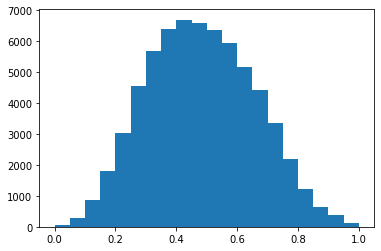

In [5]:
plt.hist(data["response"].numpy(), bins=20)
plt.show()

## Modeling in pyroed

Specify the design space via SCHEMA, CONSTRAINTS, FEATURE_BLOCKS, and GIBBS_BLOCKS.

In [6]:
SCHEMA = OrderedDict()
for n in range(8):
    SCHEMA[f"Nucleotide{n}"] = ["A", "C", "G", "T"]

CONSTRAINTS = []  # No constraints.

singletons = [[name] for name in SCHEMA]
pairs = [list(ns) for ns in zip(SCHEMA, list(SCHEMA)[1:])]
triples = [list(ns) for ns in zip(SCHEMA, list(SCHEMA)[1:], list(SCHEMA)[2:])]

FEATURE_BLOCKS = singletons + pairs
GIBBS_BLOCKS = triples

Let's start with a random subsample of data.

In [25]:
full_size = len(data["response"])
batch_size = 10
ids = torch.randperm(full_size)[:batch_size]
experiment = {k: v[ids] for k, v in data.items()}
print(f"Best response = {experiment['response'].max():0.6g}")

Best response = 0.782111


Each step of the OED process we'll test on new data. Let's make a helper to simulate lab work.

In [27]:
seq_to_id = {tuple(row): i for i, row in enumerate(data["sequences"].tolist())}

def update_experiment(experiment: dict, design: set) -> dict:
    batch_id = experiment["batch_id"].max().item() + 1
    ids = list(map(seq_to_id.__getitem__, sorted(design)))
    new_data = {
        "sequences": data["sequences"][ids],
        "batch_id": torch.full((len(ids),), batch_id),
        "response": data["response"][ids],
    }
    experiment = {k: torch.cat([v, new_data[k]]) for k, v in experiment.items()}
    print(f"Best response = {experiment['response'].max():0.6g}")
    return experiment

def make_design(experiment: dict) -> set:
    return thompson_sample(
        SCHEMA,
        CONSTRAINTS,
        FEATURE_BLOCKS,
        GIBBS_BLOCKS,
        experiment,
        inference="svi",
        svi_num_steps=201,
        sa_num_steps=201,
        log_every=0,
    )

Initialize our sequence of experiments:

In [39]:
pyro.set_rng_seed(20220308)
experiments = [experiment]

Let's start with a single loop of active learning:

In [40]:
%%time
design = make_design(experiments[-1])
print("Design:\n", pprint(design))
experiments.append(update_experiment(experiments[-1], design))

svi step 0 loss = 227.31
svi step 100 loss = 115.033
svi step 200 loss = 97.2491
..........{(0, 0, 0, 1, 0, 3, 1, 2),
 (0, 2, 1, 3, 2, 0, 1, 3),
 (0, 3, 3, 3, 3, 0, 3, 2),
 (1, 3, 3, 1, 0, 2, 0, 2),
 (2, 0, 0, 1, 0, 3, 0, 0),
 (2, 0, 3, 1, 0, 3, 2, 2),
 (2, 1, 0, 3, 1, 0, 2, 2),
 (2, 3, 3, 3, 1, 2, 2, 3),
 (3, 2, 0, 0, 1, 3, 2, 1),
 (3, 2, 2, 2, 2, 3, 0, 1)}
Design:
 None
Best response = 0.782111
CPU times: user 7.27 s, sys: 80.9 ms, total: 7.35 s
Wall time: 7.44 s


Let's run multiple loops, say 10 more loops.

In [42]:
%%time
for step in range(10):
    design = make_design(experiments[-1])
    experiments.append(update_experiment(experiments[-1], design))

svi step 0 loss = 328.547
svi step 100 loss = 182.354
svi step 200 loss = 157.066
..........Best response = 0.782111
svi step 0 loss = 397.759
svi step 100 loss = 223.998
svi step 200 loss = 180.877
..........Best response = 0.785384
svi step 0 loss = 474.64
svi step 100 loss = 261.103
svi step 200 loss = 246.654
..........Best response = 0.785384
svi step 0 loss = 436.659
svi step 100 loss = 243.204
svi step 200 loss = 227.365
..........Best response = 0.785384
svi step 0 loss = 569.2
svi step 100 loss = 335.63
svi step 200 loss = 279.575
..........Best response = 0.785384
svi step 0 loss = 519.949
svi step 100 loss = 324.831
svi step 200 loss = 255.933
..........Best response = 0.785384
svi step 0 loss = 554.253
svi step 100 loss = 344.403
svi step 200 loss = 267.959
..........Best response = 0.785384
svi step 0 loss = 625.767
svi step 100 loss = 362.4
svi step 200 loss = 274.814
..........Best response = 0.88285
svi step 0 loss = 621.583
svi step 100 loss = 381.962
svi step 200 loss

How did the response improve over time?

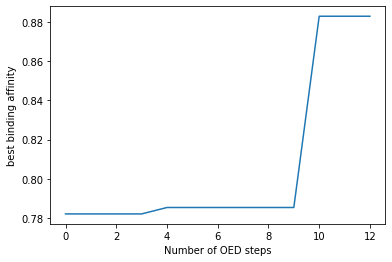

In [44]:
responses = [e["response"].max().item() for e in experiments]
plt.plot(responses)
plt.xlabel("Number of OED steps")
plt.ylabel("best binding affinity");